# Iterative Random Forest Prediction
### Using Bachelorette Data, Predicts the Winner Each Week

In [1]:
# load in libraries
import pandas as pd
import numpy as np
%matplotlib inline
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

In [2]:
# load in data file
ette_all = pd.read_csv('bachelorette_forprediction.csv')

In [3]:
ette_all[['PERC_CHOOSE_1', 'PERC_CHOOSE_2', 'PERC_CHOOSE_3', 'PERC_CHOOSE_4',
       'PERC_CHOOSE_5', 'PERC_CHOOSE_6', 'PERC_CHOOSE_7', 'PERC_CHOOSE_8',
       'PERC_CHOOSE_9', 'PERC_CHOOSE_10', 'PERC_WIN_1', 'PERC_WIN_2', 'PERC_WIN_3', 'PERC_WIN_4',
       'PERC_WIN_5', 'PERC_WIN_6', 'PERC_WIN_7', 'PERC_WIN_8',
       'PERC_WIN_9', 'PERC_WIN_10', 'PERC_POS_1', 'PERC_POS_2', 'PERC_POS_3', 'PERC_POS_4',
       'PERC_POS_5', 'PERC_POS_6', 'PERC_POS_7', 'PERC_POS_8',
       'PERC_POS_9', 'PERC_POS_10', 'PERC_NEG_1', 'PERC_NEG_2', 'PERC_NEG_3', 'PERC_NEG_4',
       'PERC_NEG_5', 'PERC_NEG_6', 'PERC_NEG_7', 'PERC_NEG_8',
       'PERC_NEG_9', 'PERC_NEG_10', 'PERC_NEU_1', 'PERC_NEU_2', 'PERC_NEU_3', 'PERC_NEU_4',
       'PERC_NEU_5', 'PERC_NEU_6', 'PERC_NEU_7', 'PERC_NEU_8',
       'PERC_NEU_9', 'PERC_NEU_10']] = ette_all[['PERC_CHOOSE_1', 'PERC_CHOOSE_2', 'PERC_CHOOSE_3', 'PERC_CHOOSE_4',
       'PERC_CHOOSE_5', 'PERC_CHOOSE_6', 'PERC_CHOOSE_7', 'PERC_CHOOSE_8',
       'PERC_CHOOSE_9', 'PERC_CHOOSE_10', 'PERC_WIN_1', 'PERC_WIN_2', 'PERC_WIN_3', 'PERC_WIN_4',
       'PERC_WIN_5', 'PERC_WIN_6', 'PERC_WIN_7', 'PERC_WIN_8',
       'PERC_WIN_9', 'PERC_WIN_10', 'PERC_POS_1', 'PERC_POS_2', 'PERC_POS_3', 'PERC_POS_4',
       'PERC_POS_5', 'PERC_POS_6', 'PERC_POS_7', 'PERC_POS_8',
       'PERC_POS_9', 'PERC_POS_10', 'PERC_NEG_1', 'PERC_NEG_2', 'PERC_NEG_3', 'PERC_NEG_4',
       'PERC_NEG_5', 'PERC_NEG_6', 'PERC_NEG_7', 'PERC_NEG_8',
       'PERC_NEG_9', 'PERC_NEG_10', 'PERC_NEU_1', 'PERC_NEU_2', 'PERC_NEU_3', 'PERC_NEU_4',
       'PERC_NEU_5', 'PERC_NEU_6', 'PERC_NEU_7', 'PERC_NEU_8',
       'PERC_NEU_9', 'PERC_NEU_10']].fillna(0)

## Functions

#### Weighting Variables

In [4]:
# extent_type == 0 -- all variables, weighting
# extent_type == 1 -- past/current variables
# extent_type == 2 -- percentage variables
def weighting(data_set, current_week, varlist, extent_type):
    if extent_type == 0:
        n = 1

        #print(current_week)
        while current_week > 0: 
            varcount = 0
            for each in varlist: 
                if varcount < 3: 
                    varuse = each + str(current_week)
                    data_set[varuse] = data_set[varuse] * n
                else: 
                    varuse = str(current_week + 1) + each
                    data_set[varuse] = data_set[varuse] * n
                varcount = varcount + 1

            current_week = current_week - 1
            n = n - 0.1
            
    if extent_type == 1: 
        # only affect the "past" cumulative variable
        variable_list = data_set.columns
        for each in variable_list: 
            if each[:4] == 'PAST_':
                data_set[each] = data_set[each] * 0.5
                
    if extent_type == 2:
        n = 1

        #print(current_week)
        while current_week > 0: 
            varcount = 0
            for each in varlist: 
                if varcount < 3: 
                    varuse = each + str(current_week)
                    data_set[varuse] = data_set[varuse] * n
                varcount = varcount + 1

            current_week = current_week - 1
            n = n - 0.1
                
    return(data_set)

#### Prediction System

In [8]:

# weighting = 3 -- only use weights with normalized tweets, 
# weighting choice - 2 = do past/current weighting, 
# 1 = do weekly weights, 0 = don't

# wtc = 0 = WINNER, 1 = Top 3
# senti = 0 = no sentiment, 1 = use sentiment
# comb = 0 then full set, 1 = past/current, 2 = full set but normalized

def prediction_system(test_bach, train_bach, weighting_choice, wtc, senti, comb, model_choice):
    week = 1
    
    if wtc == 0: 
        # 'Occupation', 'Agreement_1', 'Hometown'
        vars_to_use = ['WINNER', 'NAME', 'AGE', 'AGE_DIFF_CAT', 'SAME_STATE', 'SAME_REGION', 'SAME_OCCUPATIONGROUP'] ### will need  to add other relevant predictor variables 
        keep_set = test_bach[['NAME', 'WINNER']].copy()
    if wtc == 1: 
        vars_to_use = ['TOP_THREE', 'NAME', 'AGE', 'AGE_DIFF_CAT', 'SAME_STATE', 'SAME_REGION', 'SAME_OCCUPATIONGROUP']
        keep_set = test_bach[['NAME', 'TOP_THREE']].copy()
        
        
    while week <= 10: # ten weeks of data available

        fir = 'FIR-'
        rose = 'ROSE-'
        dates = 'DATES-'
        if senti == 1:
            neg = '.0-Negative'
            pos = '.0-Positive'
            neu = '.0-Neutral'
            tot = '.0-Total'
            choose = '.0-choose'
            win = '.0-win'
            sentis = [neg, pos, neu, tot, choose, win]
        if comb == 1: 
            pastneg = 'PAST_NEG_'
            pastpos = 'PAST_POS_'
            pastneu = 'PAST_NEU_'
            pasttot = 'PAST_TOT_'
            pastchoose = 'PAST_CHOOSE_'
            pastwin = 'PAST_WIN_'
            pasts = [pastneg, pastpos, pastneu, pasttot, pastchoose, pastwin]
        if comb == 2: 
            percneg = 'PERC_NEG_'
            percpos = 'PERC_POS_'
            percneu = 'PERC_NEU_'
            percchoose = 'PERC_CHOOSE_'
            percwin = 'PERC_WIN_'
            percs = [percneg, percpos, percneu, percchoose, percwin]
            
        if senti == 1: 
            varlist = [fir, rose, dates, neg, pos, neu, tot, choose, win]
        if senti == 0: 
            varlist = [fir, rose, dates]

        new_var = fir + str(week)
        vars_to_use.append(new_var)

        new_var2 = rose + str(week)
        vars_to_use.append(new_var2)

        new_var3 = dates + str(week)
        vars_to_use.append(new_var3)
        
        if senti == 0 and comb == 2:
            for each in percs: 
                new_var4 = each + str(week)
                vars_to_use.append(new_var4)
        
        if senti == 1 and comb == 0: 
            new_var4 = str(week + 1) + neg
            vars_to_use.append(new_var4)

            new_var5 = str(week + 1) + pos 
            vars_to_use.append(new_var5)

            new_var6 = str(week + 1) + neu
            vars_to_use.append(new_var6)

            new_var7 = str(week + 1) + tot 
            vars_to_use.append(new_var7)

            new_var8 = str(week + 1) + choose 
            vars_to_use.append(new_var8)

            new_var9 = str(week + 1) + win 
            vars_to_use.append(new_var9)
            
            
        if senti == 1 and comb == 1 and week <= 2: 
            # add in current week numbers
            # remove past weeks
            # include PASTs
            
            for each in sentis: 
                
                new_var4 = str(week + 1) + each
                vars_to_use.append(new_var4)
                    
        if senti == 1 and comb == 1 and week == 3: 
            # add in current week numbers
            # remove past weeks
            # include PASTs
            
            for each in sentis: 
                
                new_var4 = str(week + 1) + each
                vars_to_use.append(new_var4)
                
                new_var4 = str(week) + each
                vars_to_use.remove(new_var4)
            
                new_var4 = str(week - 1) + each
                vars_to_use.remove(new_var4)
            
            for each in pasts: 
                new_var4 = each + str(week + 1) 
                vars_to_use.append(new_var4)
                
                #if week > 3: 
                #    new_var4 = each + str(week - 1)
                #    vars_to_use.remove(new_var4)
                    
            
        if senti == 1 and comb == 1 and week > 3: 
            # add in current week numbers
            # remove past weeks
            # include PASTs
            
            for each in sentis: 
                
                new_var4 = str(week + 1) + each
                vars_to_use.append(new_var4)
                
                new_var4 = str(week) + each
                vars_to_use.remove(new_var4)
            
                #new_var4 = str(week - 1) + each
                #vars_to_use.remove(new_var4)
            
            for each in pasts: 
                new_var4 = each + str(week + 1) 
                vars_to_use.append(new_var4)
                
                
                new_var4 = each + str(week)
                vars_to_use.remove(new_var4)
            
        if model_choice == 1: 
            # Random Forest model
            the_model = skens.RandomForestClassifier(n_estimators=1000,oob_score=True, criterion='entropy')
        if model_choice == 0: 
            # Naive Bayes model
            the_model = sknb.GaussianNB()
        
        # train on correct variables based on week
        ### need 'WINNER' binary as right/wrong
        this_train = train_bach[vars_to_use].copy()
        if weighting == 1: 
            this_train = weighting(this_train, week, varlist, 0)
        if weighting == 2: # only use with past/current
            this_train = weighting(this_train, week, varlist, 1)
        if weighting == 3: 
            this_train = weighting(this_train, week, varlist, 2)
        #print(week)
        #print(vars_to_use)

        # train model on our train set
        if wtc == 0: 
            the_model.fit(this_train[vars_to_use[2:]], this_train.WINNER)
        if wtc == 1: 
            the_model.fit(this_train[vars_to_use[2:]], this_train.TOP_THREE)
            
        # set up test set
        this_test = test_bach[vars_to_use].copy()
        if weighting == 1:
            this_test = weighting(this_test, week, varlist)

        # test on correct variables based on week
        # hide winners
        predicted_labels = the_model.predict(this_test[vars_to_use[2:]])

        # add in predictions
        pred_week = 'PREDICTED' + str(week)
        this_test[pred_week] = predicted_labels
        if wtc == 0:
            to_output = this_test[['NAME', 'WINNER', pred_week]].copy()
            keep_set = keep_set.merge(to_output, on = ['NAME', 'WINNER'], how = 'left')
        if wtc == 1: 
            to_output = this_test[['NAME', 'TOP_THREE', pred_week]].copy()
            keep_set = keep_set.merge(to_output, on = ['NAME', 'TOP_THREE'], how = 'left')
            
        # remove contestants based on ELIMINATION
        e_week_name = 'ELIMINATION-' + str(week)

        # keep them if their elimination value is null or is R (rose)
        test_bach = test_bach[(test_bach[e_week_name].isnull()) | (test_bach[e_week_name] == 'R') | (test_bach[e_week_name] == 'R1')]
        train_bach = train_bach[(train_bach[e_week_name].isnull()) | (train_bach[e_week_name] == 'R') | (train_bach[e_week_name] == 'R1')]
        #print(len(test_bach))
        #print(len(train_bach))

        # increment time
        week = week + 1
        
    return(keep_set)


#### Evaluation Metric Calculation

In [6]:
# accuracy = (true positive + true negative) / total examples
# true positive = WINNER == 1 and PREDICTED == 1
# true negative = WINNER == 0 and PREDICTED == 0
# total examples = count(PREDICTED)
# wtc = 0 = WINNER, 1 = Top 3

def metric_calc(keep_set, wtc):
    week = 1
    metrics = {}
    
    if wtc == 0: 
        vari = 'WINNER'
    if wtc == 1: 
        vari = 'TOP_THREE'
        
    while week <= 10:
        tp = 'TRUE_POSITIVE_' + str(week)
        tn = 'TRUE_NEGATIVE_' + str(week)
        fp = 'FALSE_POSITIVE_' + str(week)
        fn = 'FALSE_NEGATIVE_' + str(week)
        predict_use = 'PREDICTED' + str(week)
        keep_set[tp] = np.where((keep_set[vari] == 1) & (keep_set[predict_use] == 1), 1, 0)
        keep_set[tn] = np.where((keep_set[vari] == 0) & (keep_set[predict_use] == 0), 1, 0)
        keep_set[fp] = np.where((keep_set[vari] == 0) & (keep_set[predict_use] == 1), 1, 0)
        keep_set[fn] = np.where((keep_set[vari] == 1) & (keep_set[predict_use] == 0), 1, 0)

        total_examples = keep_set[predict_use].count()

        accuracy = (keep_set[tp].sum() + keep_set[tn].sum()) / total_examples
        accuracy_use = 'ACCURACY_' + str(week)
        metrics[accuracy_use] = accuracy

        precision = keep_set[tp].sum() / (keep_set[tp].sum() + keep_set[fp].sum())
        precision_use = 'PRECISION_' + str(week)
        metrics[precision_use] = precision

        recall = keep_set[tp].sum() / (keep_set[tp].sum() + keep_set[fn].sum())
        recall_use = 'RECALL_' + str(week)
        metrics[recall_use] = recall

        f1 = 2 * ((precision * recall)/(precision + recall))
        f1_use = 'F1_'+ str(week)
        metrics[f1_use] = f1

        week = week + 1

    evaluation = pd.DataFrame(metrics, index=range(len(metrics)))
    evaluation = pd.DataFrame(evaluation.iloc[0])
    evaluation['Category'] = evaluation.index
    evaluation[['Metric', 'Week']] = evaluation['Category'].str.split('_',expand=True)
    evaluation = evaluation[['Metric', 'Week', 0]]
    evaluation.columns = ['Metric', 'Week', 'Value']
    
    return(evaluation)


In [15]:

def count_predictions(keep_set):
    week = 1
    counts = {}
        
    while week <= 10:
        predict_use = 'PREDICTED' + str(week)
        counts[week] = keep_set[predict_use].sum(axis=0)
        week = week + 1
    
    return(counts)


#### Plotting Evaluation Metrics

In [7]:
#save indicates whether to save or not, default is 0, to save, set save = 1
def plot_metrics(data_bit,Title,save = 0):    
    fig = plt.figure(figsize=(20,10))

    plt.subplot(221)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'PRECISION'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('PRECISION')

    plt.subplot(223)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'ACCURACY'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('ACCURACY')

    plt.subplot(222)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'RECALL'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('RECALL')

    plt.subplot(224)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'F1'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('F1')
    
    fig.suptitle(Title, fontsize=16)

    if save == 1:
        plt.savefig(Title)
    
    plt.show()
# # 
#     for each_type in metric_types: 
#         plt.plot("Week", "Value", data=data_bit[data_bit.Metric == each_type], linestyle='-', marker='o')
#         plt.ylim(-0.1,1.1)
#         plt.xlim(-0.5,10)
#         plt.title(each_type)
#         plt.show()

## Code to Run

In [9]:
# weighting = 3 -- only use weights with normalized tweets, 
# weighting choice - 2 = do past/current weighting, 
# 1 = do weekly weights, 0 = don't

# wtc = 0 = WINNER, 1 = Top 3
# senti = 0 = no sentiment, 1 = use sentiment
# comb = 0 then full set, 1 = past/current, 2 = full set but normalized
# model choice = 0 for NB, 1 for RF
test_bach = ette_all[ette_all.SEASON == 14].copy()
train_bach = ette_all[ette_all.SEASON != 14].copy()

# weighting_choice, wtc, senti, comb, model_choice
keep_set = prediction_system(test_bach, train_bach, 0, 1, 1, 0, 0)

In [37]:
def define_choice(tup_comb):
    #print(tup_comb)
    option_dict = {"weights":{0:"NoWeights", 1:"WeeklyWeights", 2:"PastCurrentWeights", 3:"NormalizedWeights"}, 
              "tochoose":{0:"Winner", 1:"Top3"}, 
              "sentiment":{0:"NoSentiment", 1:"YesSentiment"},
              "combination":{0:"FullTweets", 1:"PastCurrentTweets", 2:"NormalizedTweets"}, 
              "model":{0:"NaiveBayes", 1:"RandomForest"}}
    
    option_list = ["weights", "tochoose", "sentiment", "combination", "model"]
    n = 0
    co = []
    for each in option_list: 
        selected = option_dict[each][tup_comb[n]]
        co.append(selected)
        n = n + 1
    
    return(co)
    

In [40]:
# weighting = 3 -- only use weights with normalized tweets, 
# weighting choice - 2 = do past/current weighting, 
# 1 = do weekly weights, 0 = don't

# wtc = 0 = WINNER, 1 = Top 3
# senti = 0 = no sentiment, 1 = use sentiment
# comb = 0 then full set, 1 = past/current, 2 = full set but normalized
# model choice = 0 for NB, 1 for RF

combinations = [(0,1,0,0,1), (0,1,1,0,1), (1,1,1,0,1), (0,1,1,2,1), (0,1,1,1,1), #top3, RF
                (0,0,0,0,1), (0,0,1,0,1), (1,0,1,0,1), (0,0,1,2,1), (0,0,1,1,1), #winner, RF
                (0,1,0,0,0), (0,1,1,0,0), (1,1,1,0,0), (0,1,1,2,0), (0,1,1,1,0), #top3, NB
                (0,0,0,0,0), (0,0,1,0,0), (1,0,1,0,0), (0,0,1,2,0), (0,0,1,1,0)] #winner, NB

for each in combinations: 
    try: 
        keep_set = prediction_system(test_bach, train_bach, *each)
        c = define_choice(each)
        print(c)
        countset = count_predictions(keep_set)
        print(countset)
    except: 
        print("Combination {} didn't work".format(each))
        

['NoWeights', 'Top3', 'NoSentiment', 'FullTweets', 'RandomForest']
{1: 0, 2: 1.0, 3: 2.0, 4: 1.0, 5: 2.0, 6: 3.0, 7: 3.0, 8: 3.0, 9: 3.0, 10: 2.0}
['NoWeights', 'Top3', 'YesSentiment', 'FullTweets', 'RandomForest']
{1: 0, 2: 0.0, 3: 0.0, 4: 2.0, 5: 2.0, 6: 3.0, 7: 3.0, 8: 4.0, 9: 3.0, 10: 2.0}
['WeeklyWeights', 'Top3', 'YesSentiment', 'FullTweets', 'RandomForest']
{1: 0, 2: 0.0, 3: 0.0, 4: 2.0, 5: 3.0, 6: 3.0, 7: 3.0, 8: 4.0, 9: 3.0, 10: 2.0}
['NoWeights', 'Top3', 'YesSentiment', 'NormalizedTweets', 'RandomForest']
{1: 0, 2: 1.0, 3: 2.0, 4: 1.0, 5: 2.0, 6: 3.0, 7: 3.0, 8: 3.0, 9: 3.0, 10: 2.0}
['NoWeights', 'Top3', 'YesSentiment', 'PastCurrentTweets', 'RandomForest']
{1: 0, 2: 0.0, 3: 0.0, 4: 2.0, 5: 2.0, 6: 0.0, 7: 3.0, 8: 4.0, 9: 3.0, 10: 2.0}
['NoWeights', 'Winner', 'NoSentiment', 'FullTweets', 'RandomForest']
{1: 0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
['NoWeights', 'Winner', 'YesSentiment', 'FullTweets', 'RandomForest']
{1: 0, 2: 0.0, 3: 0.0, 4:

In [48]:
# wtc = 0 = WINNER, 1 = Top 3
# def metric_calc(keep_set, wtc):

top3numbers = metric_calc(keep_set, 1)
top3numbers

,Metric,Week,Value
ACCURACY_1,ACCURACY,1,0.821429
PRECISION_1,PRECISION,1,0.250000
RECALL_1,RECALL,1,0.333333
F1_1,F1,1,0.285714
ACCURACY_2,ACCURACY,2,0.809524
PRECISION_2,PRECISION,2,0.333333
RECALL_2,RECALL,2,0.333333
F1_2,F1,2,0.333333
ACCURACY_3,ACCURACY,3,0.833333
PRECISION_3,PRECISION,3,0.500000


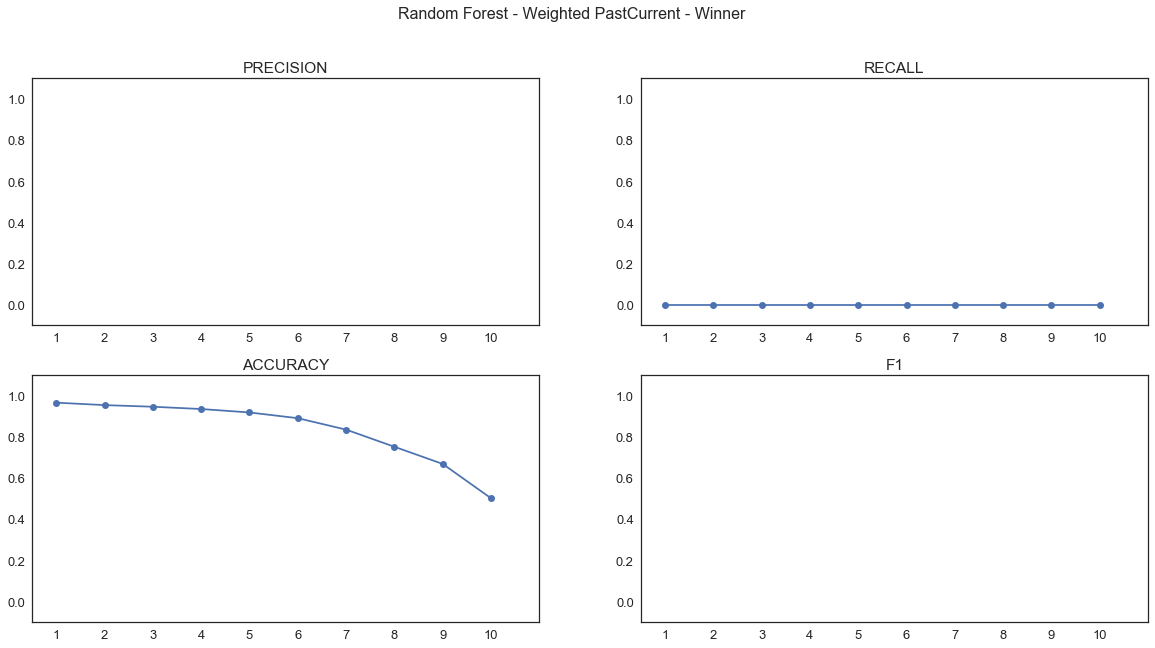

In [36]:
plot_metrics(top3numbers, "Random Forest - Weighted PastCurrent - Winner", 1)

In [13]:
#'PAST_NEG_4', 'PAST_POS_4', 'PAST_NEU_4', 'PAST_TOT_4', 'PAST_CHOOSE_4', 'PAST_WIN_4' --> 11
past_bit = ette_all[['NAME', 'SEASON', 'PAST_NEG_4', 'PAST_POS_4', 'PAST_NEU_4', 'PAST_TOT_4', 'PAST_CHOOSE_4', 'PAST_WIN_4', 
                     'PAST_NEG_5', 'PAST_POS_5', 'PAST_NEU_5', 'PAST_TOT_5', 'PAST_CHOOSE_5', 'PAST_WIN_5', 
                    'PAST_NEG_6', 'PAST_POS_6', 'PAST_NEU_6', 'PAST_TOT_6', 'PAST_CHOOSE_6', 'PAST_WIN_6', 
                    'PAST_NEG_7', 'PAST_POS_7', 'PAST_NEU_7', 'PAST_TOT_7', 'PAST_CHOOSE_7', 'PAST_WIN_7', 
                    'PAST_NEG_8', 'PAST_POS_8', 'PAST_NEU_8', 'PAST_TOT_8', 'PAST_CHOOSE_8', 'PAST_WIN_8', 
                    'PAST_NEG_9', 'PAST_POS_9', 'PAST_NEU_9', 'PAST_TOT_9', 'PAST_CHOOSE_9', 'PAST_WIN_9', 
                    'PAST_NEG_10', 'PAST_POS_10', 'PAST_NEU_10', 'PAST_TOT_10', 'PAST_CHOOSE_10', 'PAST_WIN_10',
                    'PAST_NEG_11', 'PAST_POS_11', 'PAST_NEU_11', 'PAST_TOT_11', 'PAST_CHOOSE_11', 'PAST_WIN_11']]
past_bit = pd.melt(past_bit, id_vars=['NAME', 'SEASON'])
past_bit.head()

,NAME,SEASON,variable,value
0,Garrett Yrigoyen,14,PAST_NEG_4,14.5
1,Blake Horstmann,14,PAST_NEG_4,10.0
2,Jason Tartick,14,PAST_NEG_4,2.5
3,Colton Underwood,14,PAST_NEG_4,31.5
4,Wills Reid,14,PAST_NEG_4,1.0


In [16]:
past_bit['VARIABLE'], past_bit['WEEK'] = past_bit['variable'].str.split('_', 1).str

In [18]:
past_bit['VARIABLE'], past_bit['WEEK'] = past_bit['WEEK'].str.split('_', 1).str
past_bit.head()

,NAME,SEASON,variable,value,VARIABLE,WEEK
0,Garrett Yrigoyen,14,PAST_NEG_4,14.5,NEG,4
1,Blake Horstmann,14,PAST_NEG_4,10.0,NEG,4
2,Jason Tartick,14,PAST_NEG_4,2.5,NEG,4
3,Colton Underwood,14,PAST_NEG_4,31.5,NEG,4
4,Wills Reid,14,PAST_NEG_4,1.0,NEG,4


In [25]:
past_bit[["NAME", "SEASON", "VARIABLE", "value", "WEEK"]].to_csv("past_cumulative_vars.csv")